In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from tensorflow.keras.applications import vgg19
from IPython.display import clear_output
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Content Image: Fractal Perlin Noise

## Functions

In [3]:
def plot_matrix(matrix, title="Matrix", cmap="viridis"):
    """Plot a single matrix as heatmap."""
    plt.figure(figsize=(5, 5))
    sns.heatmap(matrix, cmap=cmap, cbar=True, square=True, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.show()

In [4]:
def plot_3d_surface(height_map, title = "3D Surface Plot of Procedural Noise Map"):
    """Plot the height map as a 3D surface."""
    x = np.arange(0, height_map.shape[1])
    y = np.arange(0, height_map.shape[0])
    x, y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, height_map, cmap='terrain', linewidth=0, antialiased=True)
    ax.set_zlim(-0.5, 1.5)
    ax.view_init(elev=45, azim=60)
    plt.title(title)
    plt.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()

In [5]:
def normalize(v):
    norm = math.hypot(v[0], v[1])
    if norm == 0:
        return (0, 0)
    return (v[0] / norm, v[1] / norm)


def fade(t):
    """Smooth fading function for interpolation."""
    return t * t * t * (t * (t * 6 - 15) + 10)


def lerp(t, a, b):
    """Linear interpolation."""
    return a + t * (b - a)


def grad(hash, x, y):
    h = hash & 11  # 4 bit → 16 possible values
    g = gradients_16[h]
    return x * g[0] + y * g[1]


def perlin(x, y):
    """Compute 2D Perlin noise at position (x, y)."""
    X = int(np.floor(x)) & 255
    Y = int(np.floor(y)) & 255

    aa = permutation[permutation[X] + Y]
    ab = permutation[permutation[X] + Y + 1]
    ba = permutation[permutation[X + 1] + Y]
    bb = permutation[permutation[X + 1] + Y + 1]

    x -= np.floor(x)
    y -= np.floor(y)

    u = fade(x)
    v = fade(y)

    x1 = lerp(u, grad(aa, x, y), grad(ba, x - 1, y))
    x2 = lerp(u, grad(ab, x, y - 1), grad(bb, x - 1, y - 1))

    return lerp(v, x1, x2)


def fractal_noise_2d(x, y, octaves=6, persistence=0.5, lacunarity=2.0):
    total = 0
    amplitude = 1.0
    frequency = 1.0
    max_value = 0  # Used to normalize result

    for _ in range(octaves):
        value = perlin(x * frequency, y * frequency)
        total += value * amplitude

        frequency *= lacunarity
        amplitude *= persistence
        max_value += amplitude

    # Normalize the result to [0, 1]
    return total / max_value if max_value != 0 else 0

def generate_fractal_noise(width=256, height=256, scale=50.0, octaves=6, persistence=0.5, lacunarity=2.0):
    noise_map = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            nx = x / width
            ny = y / height
            value = fractal_noise_2d(nx * scale, ny * scale, octaves, persistence, lacunarity)
            noise_map[y][x] = value  # Already normalized to [0,1]
    return noise_map

## Generation

In [6]:
# Hashing permutation table
permutation = list(range(256))
np.random.shuffle(permutation)
permutation = permutation * 2  # Extend to allow easier wrapping

gradients_16 = [
    (math.cos(theta), math.sin(theta))
    for theta in [2 * math.pi * i / 16 for i in range(16)]
]

In [7]:
noise_map = generate_fractal_noise(512, 512, scale=5.0, octaves=2)

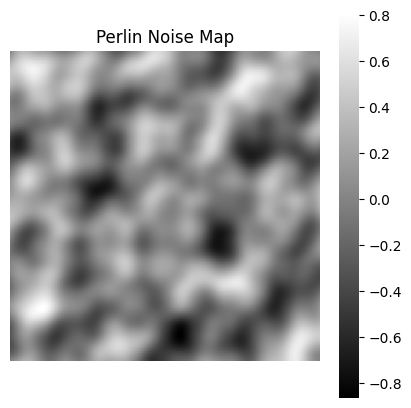

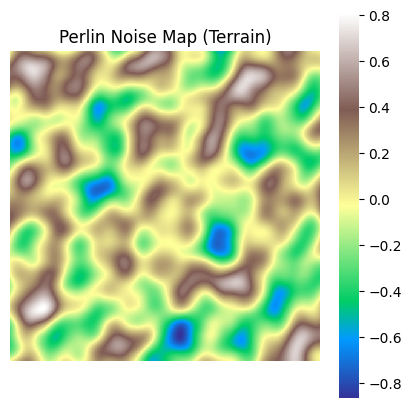

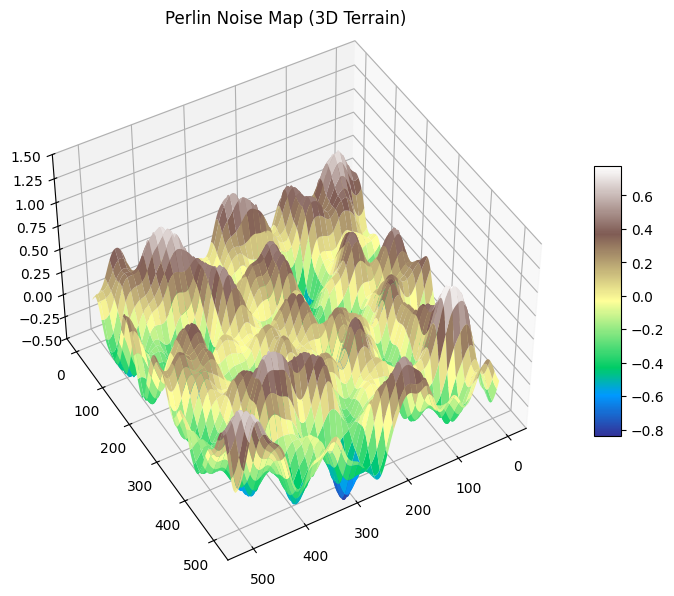

In [8]:
plot_matrix(noise_map, "Perlin Noise Map", cmap = "gray")
plot_matrix(noise_map, "Perlin Noise Map (Terrain)", cmap="terrain")
plot_3d_surface(noise_map, "Perlin Noise Map (3D Terrain)")

In [9]:
# Save the image to /content/content_map.jpg
plt.imsave('/content/content_map.jpg', noise_map, cmap='gray')

print("Image saved at /content/content_map.jpg")

Image saved at /content/content_map.jpg


# Style Image : Real World Height Map

In [34]:
drive_base_path = '/content/drive/MyDrive/Style Transfer Resources/'

#image_path = 'caucasus.jpg'
#image_path = 'fjord.jpg'
#image_path = 'himalaya.jpg'
image_path = 'river.jpg'

image_path_in_drive = drive_base_path + image_path
destination_path = '/content/style_image.jpg'

import shutil
shutil.copy(image_path_in_drive, destination_path)

print(f"Image copied to: {destination_path}")

Image copied to: /content/style_image.jpg


# Neural Style Transfer

## Functions

In [35]:
# Preprocessing functions
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Loss functions
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    # Content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    # Style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Optimization Loop

Iteration 500: loss=254.74


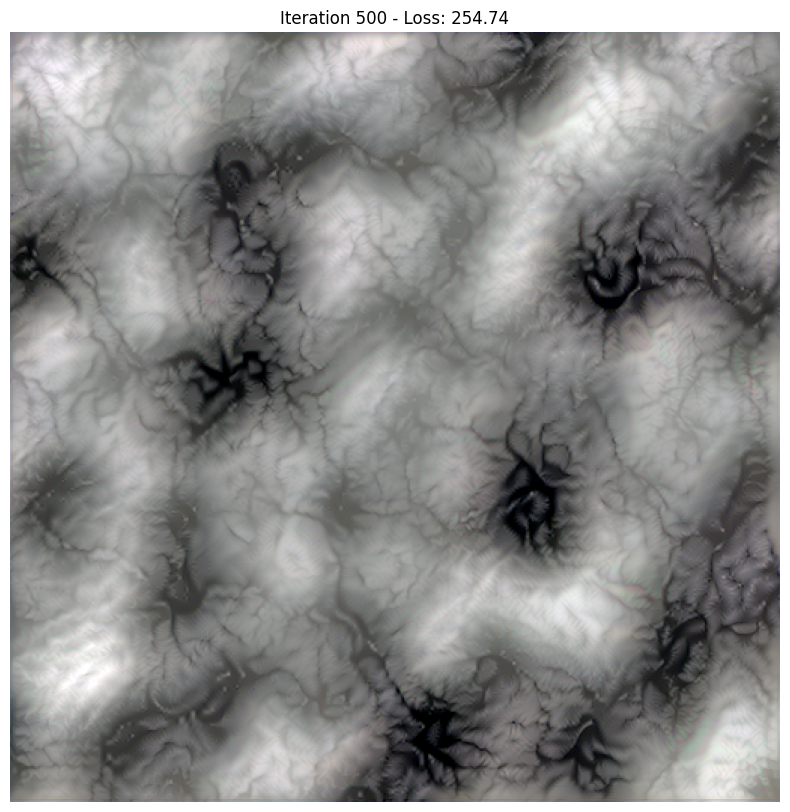

In [36]:
base_image_path = "content_map.jpg"   # Content image path
style_reference_image_path = "style_image.jpg"   # Style image path
iterations = 500   # Number of optimization steps

# Loss weights
total_variation_weight = 1e-10
style_weight = 1e-5
content_weight = 2.5e-11

# Image dimensions
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 512
img_ncols = int(width * img_nrows / height)

# VGG19 feature extractor setup
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# Transfer layers
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]
content_layer_name = "block5_conv2"

# Optimizer
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=150.0, decay_steps=100, decay_rate=0.96
    )
)

# Initialization
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

# Optimization Loop
loss_history = []
for i in range(1, iterations + 1):
    clear_output(wait=True)
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    loss_history.append(loss.numpy())

    # Every 10th iteration, plot the intermediate results
    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())

        # Plotting
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Iteration {i} - Loss: {loss:.2f}")
        plt.axis("off")
        plt.show()

Minimum Loss: 238.7449 at Iteration: 486


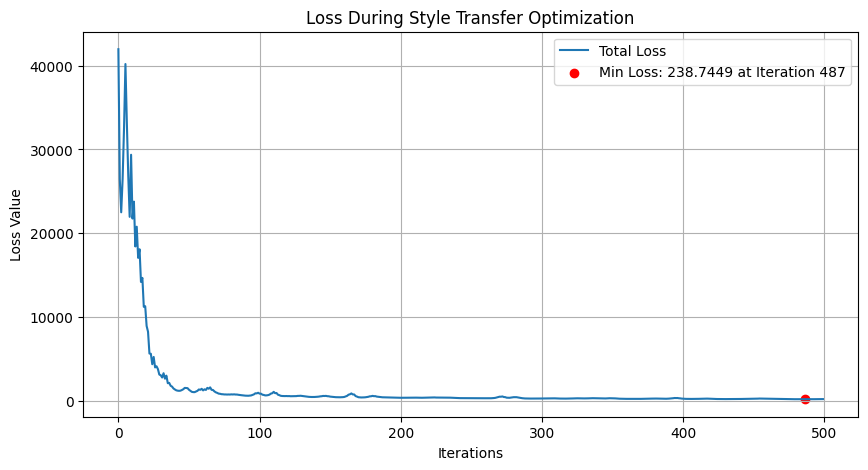

In [37]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Total Loss')
plt.title('Loss During Style Transfer Optimization')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# Find the iteration and value of the minimum loss
min_loss = min(loss_history)
min_index = loss_history.index(min_loss)

# Annotate the minimum loss point
plt.scatter(min_index, min_loss, color='red', label=f'Min Loss: {min_loss:.4f} at Iteration {min_index+1}')
plt.legend()

# Print the result
print(f"Minimum Loss: {min_loss:.4f} at Iteration: {min_index}")

plt.show()

Minimum Loss: 238.7449 at Iteration: 286


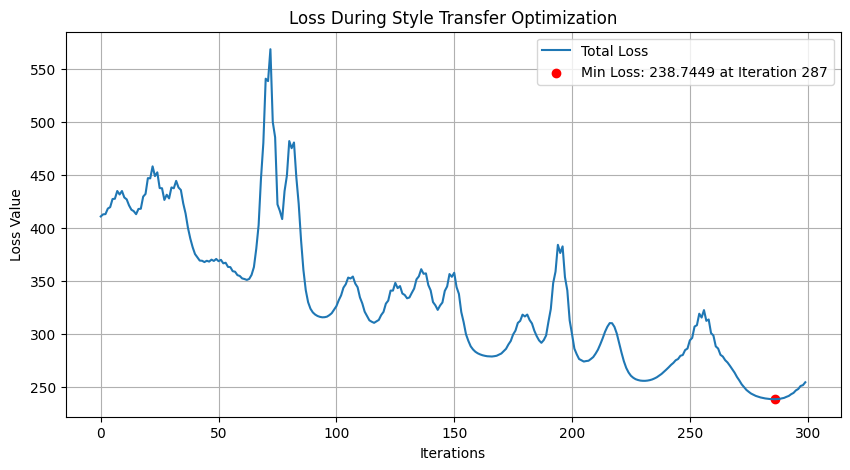

In [38]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history[200:], label='Total Loss')
plt.title('Loss During Style Transfer Optimization')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# Find the iteration and value of the minimum loss
min_loss = min(loss_history[200:])
min_index = loss_history.index(min_loss)-200

# Annotate the minimum loss point
plt.scatter(min_index, min_loss, color='red', label=f'Min Loss: {min_loss:.4f} at Iteration {min_index+1}')
plt.legend()

# Print the result
print(f"Minimum Loss: {min_loss:.4f} at Iteration: {min_index}")

plt.show()

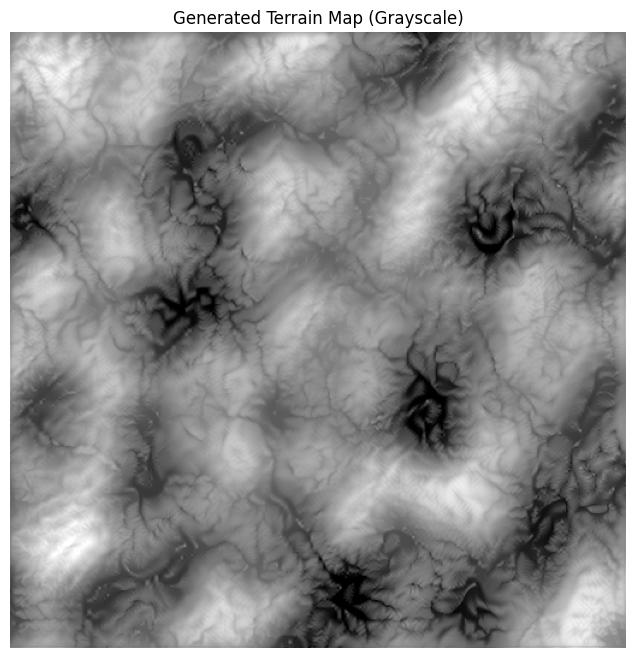

In [39]:
# Convert final image to grayscale

# Convert tensor to PIL image
final_image = deprocess_image(combination_image.numpy())
img = array_to_img(final_image)

# Convert to grayscale using PIL
gray_img = img.convert('L')

# Save grayscale version
gray_img.save('/content/generated_terrain_map_grayscale.jpg')

# Display grayscale image
plt.figure(figsize=(8, 8))
plt.imshow(gray_img, cmap='gray')
plt.title("Generated Terrain Map (Grayscale)")
plt.axis("off")
plt.show()

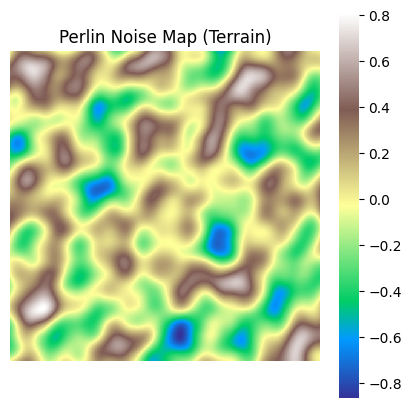

In [40]:
plot_matrix(noise_map, "Perlin Noise Map (Terrain)", cmap="terrain")

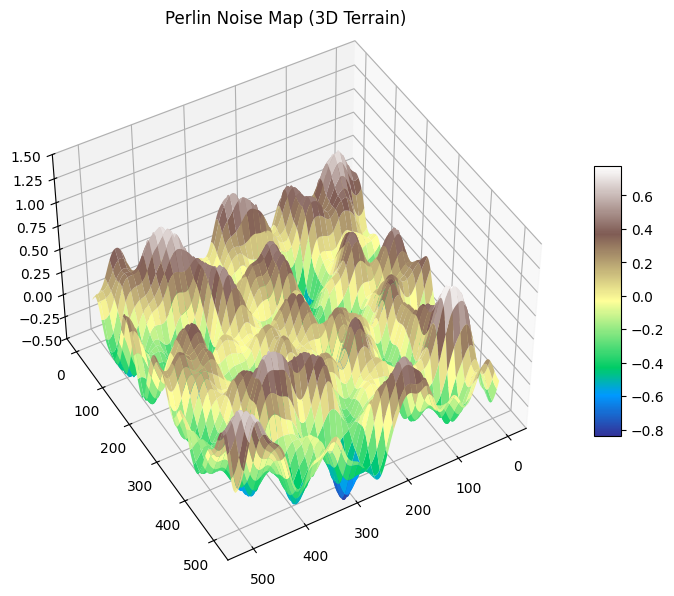

In [41]:
plot_3d_surface(noise_map, "Perlin Noise Map (3D Terrain)")

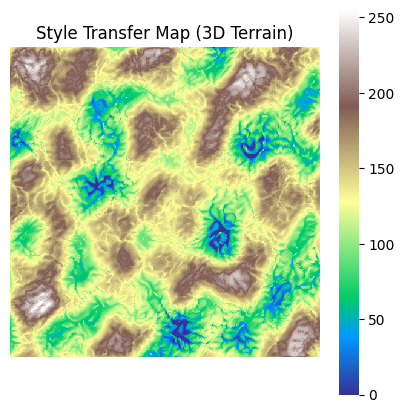

In [42]:
plot_matrix(gray_img, "Style Transfer Map (3D Terrain)", cmap="terrain")

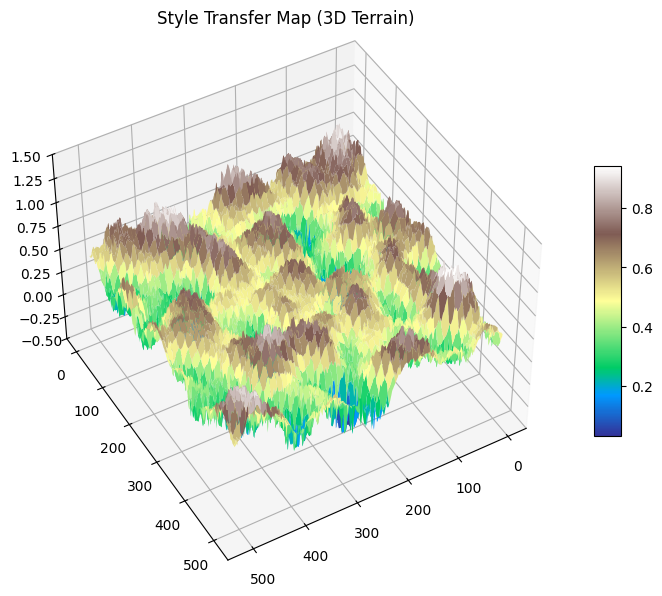

In [43]:
height_map = np.array(gray_img)
height_map = height_map.astype(np.float32) / 255.0
plot_3d_surface(height_map, "Style Transfer Map (3D Terrain)")